In [1]:
import glob
import os
import pandas as pd
from io import StringIO
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=11)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Generate subsets

In [79]:
out = !ls -lSr /cluster/work/grlab/projects/metagenome/raw_data/refseq/fna/complete.*.genomic.fna.gz \
    | awk '{print $5" "$9}'

In [80]:
sizes = []
files = []

for line in out:
    number, file = line.split(' ')
    files.append(file.split('/')[-1])
    sizes.append(int(number))

sizes = np.array(sizes)

In [81]:
num_points = 90
for i in range(num_points):
    np.savetxt('refseq_subsets/subset_{}'.format(i + 1),
               np.array(files)[:(i + 1) * len(files) // num_points],
               fmt='%s')

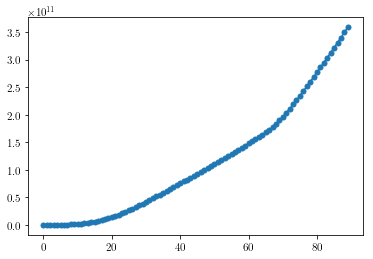

In [82]:
plt.plot([sizes[:(i + 1) * len(files) // num_points].sum() for i in range(num_points)], marker='o', ms=5)

## Variable size of the input data

In [40]:
DATA_DIR = "/cluster/work/grlab/projects/metagenome/data/refseq/refseq_var_k"

In [41]:
def get_kmers_and_ram_succinct(stats_file):
    with open(stats_file, 'r') as f:
        stats = f.read().strip()
    stats = stats.split('\n')
    num_kmers = int(stats[-28].split()[-1])
    peak_ram = int(stats[-14].split()[-1])
    return num_kmers, peak_ram

get_kmers_and_ram_succinct(DATA_DIR + '/subgraphs_k17/subset_1.dbg.stats')

(5969945, 95684)

In [42]:
results = pd.DataFrame(columns=['representation', 'k', 'num_kmers', 'RAM'])

### Succinct

In [43]:
graphs = !ls $DATA_DIR/subgraphs_k*/*.dbg.stats

num_kmers_array = []
peak_ram_array = []
k_array = []

for graph in graphs:
    k = int(graph.split('/')[-2].split('k')[-1])
    try:
        num_kmers, peak_ram = get_kmers_and_ram_succinct(graph)
    except:
        print('error in', graph)
        continue
    num_kmers_array.append(num_kmers)
    peak_ram_array.append(peak_ram)
    k_array.append(k)

new_results = pd.DataFrame(columns=results.columns,
                           data=zip(['succinct'] * len(num_kmers_array),
                                    k_array,
                                    num_kmers_array,
                                    peak_ram_array))

results = results.append(new_results)
results.shape[0]

263

### Bitmap

In [44]:
def get_kmers_and_ram(stats_file):
    with open(stats_file, 'r') as f:
        stats = f.read().strip()
    stats = stats.split('\n')
    num_kmers = int(stats[-26].split()[-1])
    peak_ram = int(stats[-14].split()[-1])
    return num_kmers, peak_ram

get_kmers_and_ram(DATA_DIR + '/subgraphs_k17/subset_10_bitmap.bitmapdbg.stats')

(2347461599, 2061876)

In [45]:
graphs = !ls $DATA_DIR/subgraphs_k*/*.bitmapdbg.stats

num_kmers_array = []
peak_ram_array = []
k_array = []

for graph in graphs:
    k = int(graph.split('/')[-2].split('k')[-1])
    try:
        num_kmers, peak_ram = get_kmers_and_ram(graph)
    except:
        print('error in', graph)
        continue
    num_kmers_array.append(num_kmers)
    peak_ram_array.append(peak_ram)
    k_array.append(k)

new_results = pd.DataFrame(columns=results.columns,
                           data=zip(['bitmap'] * len(num_kmers_array),
                                    k_array,
                                    num_kmers_array,
                                    peak_ram_array))

results = results.append(new_results)
results.shape[0]

374

### Hash

In [46]:
graphs = !ls $DATA_DIR/subgraphs_k*/*.orhashdbg.stats

num_kmers_array = []
peak_ram_array = []
k_array = []

for graph in graphs:
    k = int(graph.split('/')[-2].split('k')[-1])
    try:
        num_kmers, peak_ram = get_kmers_and_ram(graph)
    except:
        print('error in', graph)
        continue
    num_kmers_array.append(num_kmers)
    peak_ram_array.append(peak_ram)
    k_array.append(k)

new_results = pd.DataFrame(columns=results.columns,
                           data=zip(['hash'] * len(num_kmers_array),
                                    k_array,
                                    num_kmers_array,
                                    peak_ram_array))

results = results.append(new_results)
results.shape[0]

error in /cluster/work/grlab/projects/metagenome/data/refseq/refseq_var_k/subgraphs_k17/subset_9_hash.orhashdbg.stats
error in /cluster/work/grlab/projects/metagenome/data/refseq/refseq_var_k/subgraphs_k29/subset_10_hash.orhashdbg.stats
error in /cluster/work/grlab/projects/metagenome/data/refseq/refseq_var_k/subgraphs_k29/subset_1_hash.orhashdbg.stats


433

### Plot

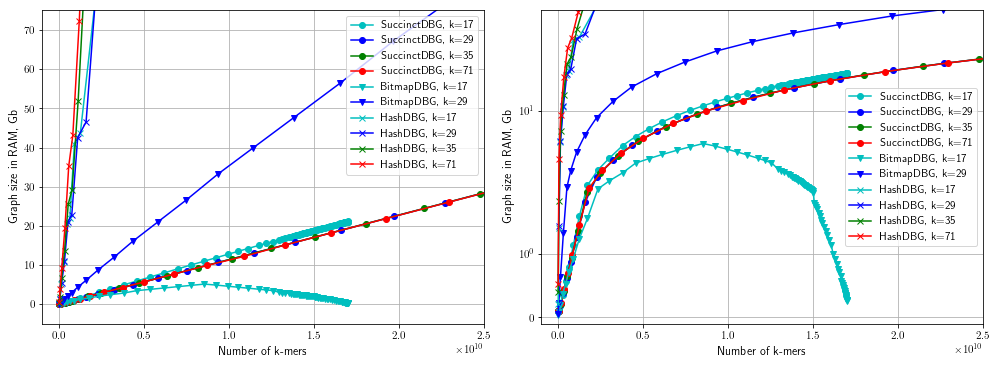

In [52]:
width = 3.487 * 1.5 * 1.6
height = width / 1.618

fig, axes = plt.subplots(1, 2, figsize=(width / 1.2 * 2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

results.sort_values('num_kmers', inplace=True)

colors = ['c', 'b', 'g', 'r']

ax = axes[0]
for ax in axes:
    df = results[(results.representation == 'succinct') & (results.k == 17)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[0], marker='o', label='SuccinctDBG, k=17')

    df = results[(results.representation == 'succinct') & (results.k == 29)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[1], marker='o', label='SuccinctDBG, k=29')

    df = results[(results.representation == 'succinct') & (results.k == 35)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[2], marker='o', label='SuccinctDBG, k=35')

    df = results[(results.representation == 'succinct') & (results.k == 71)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[3], marker='o', label='SuccinctDBG, k=71')



    df = results[(results.representation == 'bitmap') & (results.k == 17)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[0], marker='v', label='BitmapDBG, k=17')

    df = results[(results.representation == 'bitmap') & (results.k == 29)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[1], marker='v', label='BitmapDBG, k=29')

#     df = results[(results.representation == 'bitmap') & (results.k == 35)]
#     ax.plot(df.num_kmers, df.RAM / 10**6, colors[2], marker='v', label='BitmapDBG, k=35')

#     df = results[(results.representation == 'bitmap') & (results.k == 71)]
#     ax.plot(df.num_kmers, df.RAM / 10**6, colors[3], marker='v', label='BitmapDBG, k=71')



    df = results[(results.representation == 'hash') & (results.k == 17)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[0], marker='x', label='HashDBG, k=17')

    df = results[(results.representation == 'hash') & (results.k == 29)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[1], marker='x', label='HashDBG, k=29')

    df = results[(results.representation == 'hash') & (results.k == 35)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[2], marker='x', label='HashDBG, k=35')

    df = results[(results.representation == 'hash') & (results.k == 71)]
    ax.plot(df.num_kmers, df.RAM / 10**6, colors[3], marker='x', label='HashDBG, k=71')

    ax.set_xlabel('Number of k-mers')
    ax.set_ylabel('Graph size in RAM, Gb')
    ax.set_xlim([-1e9, 25e9])
    #ax.set_xticks(np.array(k_array))
    ax.grid(True)
    ax.legend(loc='best')

axes[0].set_ylim([-5, 75])
axes[1].set_ylim([-1e-1, 75])
axes[1].set_yscale('symlog')

plt.tight_layout()
plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Variable $k$

### Ref-Seq assembly data

In [2]:
k_array = np.arange(10, 24)

In [3]:
!ls ~/big_graph/refseq/refseq_k10/graph_refseq_k10.dbg

/cluster/home/mikhaika/big_graph/refseq/refseq_k10/graph_refseq_k10.dbg


In [4]:
sizes = [os.path.getsize('../big_graph/refseq/refseq_k{}/graph_refseq_k{}.dbg'.format(x, x))
             for x in k_array]
sizes

[5017397,
 19957085,
 79716413,
 318783677,
 1275200189,
 5100406198,
 20193422370,
 70555357553,
 180029209052,
 320880966947,
 424795775328,
 470859116657,
 490467611111,
 503062440506]

In [5]:
num_edges = [4194305,
16777217,
67108865,
268435457,
1073741825,
4294807964,
17004180213,
58827897766,
147478598494,
261992234631,
355110450523,
411025684461,
441788978532,
459869414309,
]

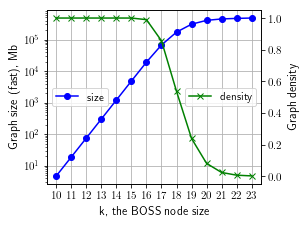

In [6]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

ax.plot(np.array(k_array), np.array(sizes) / 2**20, marker='o', label='size', c='b')
ax.set_yscale('log')
ax.set_ylabel('Graph size (fast), Mb')
ax.set_xlabel('k, the BOSS node size')
ax.set_xticks(np.array(k_array))
ax.grid(True)
ax.legend(loc='center left')

ax2 = ax.twinx()
ax2.plot(np.array(k_array), num_edges / 4 ** (np.array(k_array) + 1), marker='x', label='density', c='g')
#ax2.set_yscale('log')
ax2.set_ylabel('Graph density')
ax2.legend(loc='center right')

plt.tight_layout()
plt.savefig('refseq_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Kingsford data

In [7]:
k_array = np.concatenate((np.arange(5, 21), np.arange(22, 34, 2)))

In [8]:
!ls ~/big_graph/kingsford/var_k/graph_kingsford_k*.dbg

ls: cannot access '/cluster/home/mikhaika/big_graph/kingsford/var_k/graph_kingsford_k*.dbg': No such file or directory


In [9]:
sizes = [os.path.getsize('../big_graph/kingsford/var_k/graph_kingsford_k{}.dbg'.format(x, x)) for x in k_array]
sizes

FileNotFoundError: [Errno 2] No such file or directory: '../big_graph/kingsford/var_k/graph_kingsford_k5.dbg'

In [ ]:
num_edges = [15626,
78126,
390617,
1902278,
7468325,
24194804,
72215346,
197636600,
512173368,
1326508825,
2934716087,
4955736317,
6790193411,
8184346383,
9226858039,
10082499128,
10868326297,
11479986324,
12901835746,
14190173930,
15700483703,
17261067050,
]

In [ ]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('Kingsford graph, with replaced \'N\'s')
#ax.set_title('Kingsford assembly graph')

ax.plot(np.array(k_array), np.array(sizes) / 2**20, marker='o', label='size', c='b')
ax.set_yscale('log')
ax.set_ylabel('Graph size (fast), Mb')
ax.set_xlabel('k, the BOSS node size')
#ax.set_xticks(np.array(k_array))
ax.set_xticks([6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])
ax.grid(True)
ax.legend(loc=(0.7, 0.75))

ax2 = ax.twinx()
ax2.plot(np.array(k_array), num_edges / 5 ** (np.array(k_array) + 1), marker='x', label='density', c='g')
#ax2.set_yscale('log')
ax2.set_ylabel('Graph density')
ax2.legend(loc=(0.6, 0.1))

plt.tight_layout()
plt.savefig('kingsford_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Plots

In [ ]:
k_array_refseq = np.arange(10, 24)
sizes_refseq = [os.path.getsize('../big_graph/refseq/refseq_k{}/graph_refseq_k{}.dbg'.format(x, x)) for x in k_array_refseq]
num_edges_refseq = [4194305,
16777217,
67108865,
268435457,
1073741825,
4294807964,
17004180213,
58827897766,
147478598494,
261992234631,
355110450523,
411025684461,
441788978532,
459869414309,
]

In [ ]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

ax1_plot1 = ax.plot(np.array(k_array_refseq), np.array(sizes_refseq) / 2**20, marker='o', label='RS: size', c='b')
ax1_plot2 = ax.plot(np.array(k_array), np.array(sizes) / 2**20, marker='o', label='KF: size', c='r')
ax.set_yscale('log')
ax.set_ylabel('Graph size (fast), Mb')
ax.set_xlabel('$k$, the BOSS node size')
#ax.set_xticks(np.array(k_array))
ax.set_xticks([6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])
ax.grid(True)

ax2 = ax.twinx()
ax2_plot1 = ax2.plot(np.array(k_array_refseq), num_edges_refseq / 4 ** (np.array(k_array_refseq) + 1), marker='x', label='RS: density', c='b')
ax2_plot2 = ax2.plot(np.array(k_array), num_edges / 5 ** (np.array(k_array) + 1), marker='x', label='KF: density', c='r')
#ax2.set_yscale('log')
ax2.set_ylabel('Graph density')

lns = ax1_plot1 + ax1_plot2 + ax2_plot1 + ax2_plot2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')

plt.tight_layout()
plt.savefig('graph_k_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()